In [84]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
# Reusing wage data from capstone 1
wadf = pd.read_csv('/Users/JKovach/Documents/test projects/duptest14_Capstone1/Wage Affordability Data.csv', 
                   encoding = "ISO-8859-1")

# Clean variables, targeting state by wage data
wadf = wadf.drop(['Table_Data', 'Footnote'],1)
wadf = wadf.dropna(how='any')
wadf['Monthly.Wage'] = wadf['High.2018'] * 168

wadf.head()

,Year,State,High.Value,Low.Value,CPI.Average,High.2018,Low.2018,Rate.Inflation,Rent.Median,Monthly.Wage
0,1968,Alabama,0.00000,0.00000,34.783333,0.00,0.00,4.95,256.4,0.00
1,1968,Alaska,2.10000,2.10000,34.783333,15.12,15.12,4.95,705.0,2540.16
2,1968,Arizona,0.66000,0.46800,34.783333,4.75,3.37,4.95,403.2,798.00
3,1968,Arkansas,0.15625,0.15625,34.783333,1.12,1.12,4.95,264.8,188.16
4,1968,California,1.65000,1.65000,34.783333,11.88,11.88,4.95,465.0,1995.84


In [86]:
# Create Target
wadf['wage_diff'] = wadf['Monthly.Wage'] - wadf['Rent.Median']

def live_wage(wage):
    if wage < 0:
        return 0
    else:
        return 1

wadf['livable'] = np.nan
wadf['livable'] = wadf['wage_diff'].apply(live_wage)

# Create separate df for target and features
livability = pd.DataFrame(wadf['livable'])
features = wadf.drop(['State', 'livable', 'wage_diff'], 1)
livability.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 2694
Data columns (total 1 columns):
livable    2548 non-null int64
dtypes: int64(1)
memory usage: 39.8 KB


--- 0.24974274635314941 seconds ---


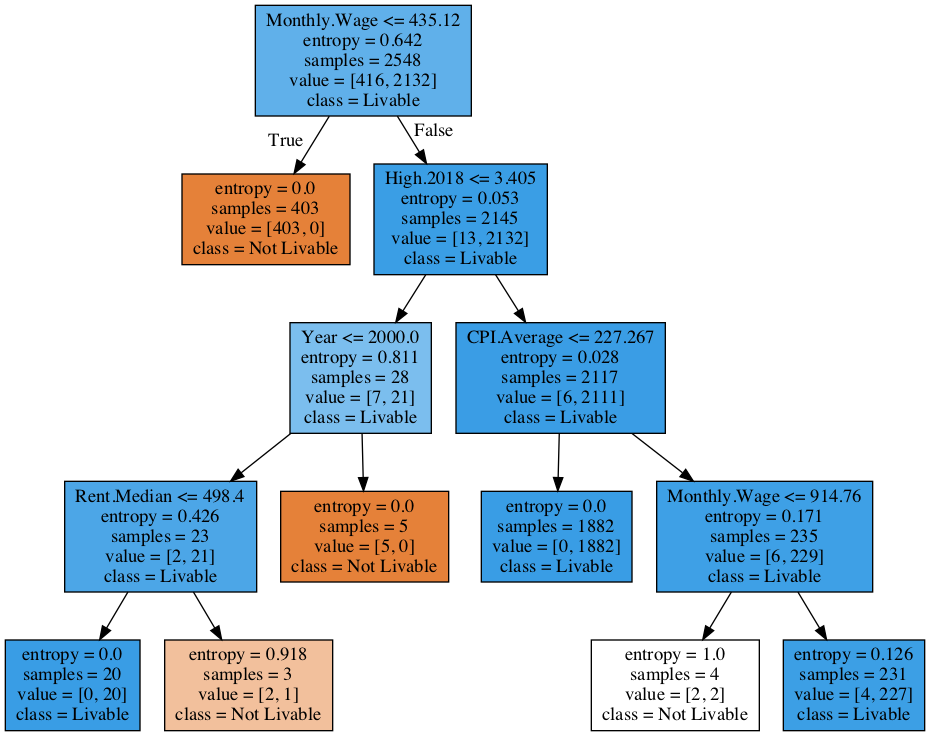

In [87]:
# Build Decision Tree
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import time

# Check start time for efficiency
tree_start_time = time.time()

# Initialize tree object.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=4,
    random_state = 465
)

# Fit tree
decision_tree.fit(features, livability)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=features.columns,
    class_names=['Not Livable', 'Livable'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
print("--- %s seconds ---" % (time.time() - tree_start_time))
Image(graph.create_png())

In [94]:
# Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# Check start time for efficiency
tree_start_time = time.time()

rfc = ensemble.RandomForestClassifier()
X = wadf.drop(['State', 'livable', 'wage_diff'], 1)
Y = wadf['livable']

print("--- %s seconds ---" % (time.time() - tree_start_time))
cross_val_score(rfc, X, Y, cv=10)

--- 0.003046274185180664 seconds ---


/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

array([1.        , 1.        , 1.        , 1.        , 0.99215686,
       0.98823529, 0.99606299, 1.        , 0.98031496, 0.97637795])

Based on what was discussed in the lesson, I would have expected the forest to be more resource intensive and take a longer amount of time. I'm concerned about the forest model being overfit, both from the time to process and the cross validation score having so many perfect values. This could be due to the simplicity of the dataset, having only 10 columns, but I also suspect my own error in building the model.